# GenRe Testing Notebook
Test GenRe integration step by step

## Setup

In [1]:
import sys
import os
import torch

# Add repo to path
repo_path = r'C:\Users\j537yu\recourse_benchmarks'
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

os.chdir(repo_path)
print(f"Working directory: {os.getcwd()}")

Working directory: C:\Users\j537yu\recourse_benchmarks


C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test 1: Import GenRe

In [2]:
try:
    from methods.catalog.genre import GenRe
    print("✅ GenRe imported successfully!")
except Exception as e:
    print(f"❌ Import failed: {e}")
    import traceback
    traceback.print_exc()

C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tensorflow\python\framework\dty



[ENV WARNING] treeUtils not available. Error: No module named 'treeUtils'


Using TensorFlow backend.


✅ GenRe imported successfully!


## Test 2: Load Data and Model

In [3]:
from data.catalog import DataCatalog
from models.catalog import ModelCatalog

print("Loading dataset...")
dataset = DataCatalog("compass", "mlp", 0.7)
print(f"✅ Dataset loaded: {len(dataset.df_train)} train, {len(dataset.df_test)} test")

print("\nLoading model...")
mlmodel = ModelCatalog(dataset, "mlp", "pytorch")
mlmodel.raw_model.eval()
print("✅ Model loaded")

print(f"\nFeatures: {mlmodel.feature_input_order}")

Loading dataset...
C:\Users\j537yu\recourse_benchmarks\data\catalog\data_catalog.yaml
[INFO] Attempting to load saved dataset (`compass`) from cache...	✅ Dataset loaded: 3150 train, 1350 test

Loading model...
C:\Users\j537yu\recourse_benchmarks\models\catalog\mlmodel_catalog.yaml
[INFO] Attempting to load saved dataset (`compass`) from cache...	[INFO] Attempting to load saved dataset (`compass`) from cache...	done.
[WARNING] From C:\Users\j537yu\.conda\envs\py37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor [deprecation.py new_func]
[INFO] Training `mlp` on 3,150 samples (%70.00 of 4,500 samples)...
[INFO] Training `mlp` on 3,150 samples (%70.00 of 4,500 samples)...
✅ Model loaded

Features: ['x0_ord_0', 'x0_ord_1', 'x0_or

## Test 2.5: check the default mlp

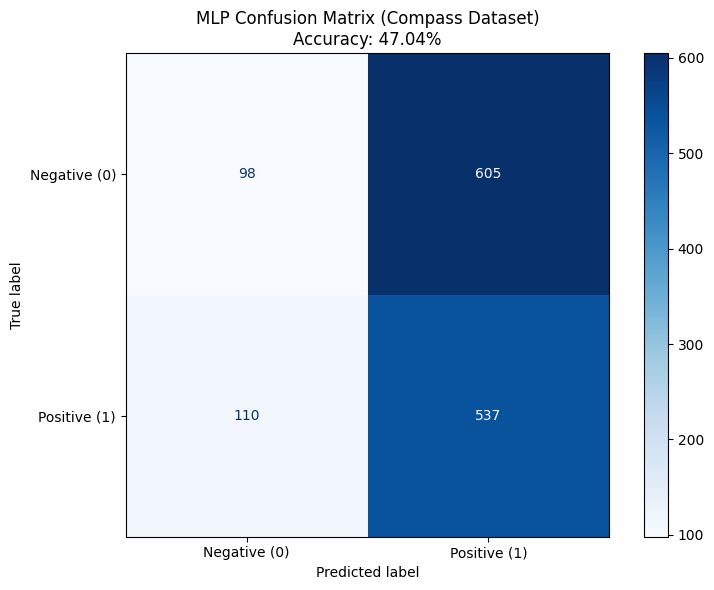


MLP Model Performance on Compass Dataset
Accuracy:  47.04%
Precision: 47.02%
Recall:    83.00%
F1 Score:  60.03%

Confusion Matrix:
  True Negative (TN):    98
  False Positive (FP):  605
  False Negative (FN):  110
  True Positive (TP):   537


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 确保模型稳定
mlmodel.raw_model.eval()

# 获取测试集预测
test_data = dataset.df_test.copy()
X_test = test_data.drop(columns=['y'])
y_true = test_data['y'].values

predictions_proba = mlmodel.predict_proba(X_test)
y_pred = (predictions_proba[:, 1] > 0.5).astype(int)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 计算指标
accuracy = (y_pred == y_true).mean()
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'MLP Confusion Matrix (Compass Dataset)\nAccuracy: {accuracy:.2%}')

plt.tight_layout()
plt.show()

# 打印详细指标
print("\n" + "="*50)
print("MLP Model Performance on Compass Dataset")
print("="*50)
print(f"Accuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1 Score:  {f1:.2%}")
print(f"\nConfusion Matrix:")
print(f"  True Negative (TN):  {TN:4d}")
print(f"  False Positive (FP): {FP:4d}")
print(f"  False Negative (FN): {FN:4d}")
print(f"  True Positive (TP):  {TP:4d}")
print("="*50)

## Test 3: Initialize GenRe

In [5]:
print("Initializing GenRe...")
try:
    genre = GenRe(mlmodel, hyperparams={
        "data_name": "compass",
        "model_path": "genre_transformer.pth",
        "temperature": 1.0,
        "n_samples": 10
    })
    print("✅ GenRe initialized successfully!")
except Exception as e:
    print(f"❌ Initialization failed: {e}")
    import traceback
    traceback.print_exc()

Initializing GenRe...
✅ GenRe initialized successfully!


## Test 4: Get Negative Instances

In [6]:
print("Finding negative instances...")
test_data = dataset.df_test.copy()
predictions_proba = mlmodel.predict_proba(test_data.drop(columns=['y']))
predictions = (predictions_proba[:, 1] > 0.5).astype(int)
true_labels = test_data['y'].values

print(f"Predictions distribution:")
print(f"  Class 0: {(predictions == 0).sum()}")
print(f"  Class 1: {(predictions == 1).sum()}")

print(f"\nAccuracy: {(predictions == true_labels).mean():.2%}")

# Use instances predicted as 0
negative_mask = predictions == 0
test_factuals = test_data[negative_mask].drop(columns=['y'])

print(f"\n✅ Found {len(test_factuals)} negative instances for testing")
print(test_factuals)

Finding negative instances...
Predictions distribution:
  Class 0: 208
  Class 1: 1142

Accuracy: 47.04%

✅ Found 208 negative instances for testing
       x1   x2        x3   x4  x0_ord_0  x0_ord_1  x0_ord_2
4780  0.0  1.0  0.052632  1.0       1.0       0.0       0.0
2800  0.0  0.0  0.500000  1.0       1.0       1.0       0.0
832   0.0  1.0  0.078947  1.0       1.0       1.0       0.0
1216  0.0  1.0  0.078947  1.0       1.0       1.0       0.0
5124  0.0  1.0  0.026316  1.0       1.0       1.0       0.0
...   ...  ...       ...  ...       ...       ...       ...
2896  0.0  1.0  0.000000  1.0       1.0       0.0       0.0
1493  1.0  0.0  0.131579  1.0       1.0       0.0       0.0
3537  0.0  1.0  0.289474  0.0       1.0       0.0       0.0
2397  1.0  1.0  0.184211  1.0       1.0       1.0       0.0
2326  0.0  0.0  0.368421  1.0       1.0       1.0       0.0

[208 rows x 7 columns]


## Test 5: Generate Counterfactual (1 instance)

In [7]:
# 在 Test 5 前添加调试
print("Debug GenRe generation:")

# 检查 factual
factual = test_factuals.head(5)
print(f"Factual shape: {factual.shape}")
print(f"Factual:\n{factual}")
print(f"Factual values:\n{factual.values}")

# 检查 Transformer 输入
factual_tensor = torch.from_numpy(factual.values).float()
print(f"Tensor shape: {factual_tensor.shape}")
print(f"Tensor device: {factual_tensor.device}")

print(f"genre._device: {genre._device}")
print(f"transformer device: {next(genre._transformer.parameters()).device}")

# 尝试生成
genre._transformer.eval()
with torch.no_grad():
    try:
        output = genre._transformer.generate(factual_tensor, temperature=1.0)
        print(f"Output shape: {output.shape}")
        print(f"Output:\n{output}")
        print(f"Output has NaN: {torch.isnan(output).any()}")
    except Exception as e:
        print(f"Generation failed: {e}")
        import traceback
        traceback.print_exc()

Debug GenRe generation:
Factual shape: (5, 7)
Factual:
       x1   x2        x3   x4  x0_ord_0  x0_ord_1  x0_ord_2
4780  0.0  1.0  0.052632  1.0       1.0       0.0       0.0
2800  0.0  0.0  0.500000  1.0       1.0       1.0       0.0
832   0.0  1.0  0.078947  1.0       1.0       1.0       0.0
1216  0.0  1.0  0.078947  1.0       1.0       1.0       0.0
5124  0.0  1.0  0.026316  1.0       1.0       1.0       0.0
Factual values:
[[0.         1.         0.05263158 1.         1.         0.
  0.        ]
 [0.         0.         0.5        1.         1.         1.
  0.        ]
 [0.         1.         0.07894737 1.         1.         1.
  0.        ]
 [0.         1.         0.07894737 1.         1.         1.
  0.        ]
 [0.         1.         0.02631579 1.         1.         1.
  0.        ]]
Tensor shape: torch.Size([5, 7])
Tensor device: cpu
genre._device: cuda
transformer device: cuda:0
Output shape: torch.Size([5, 7])
Output:
tensor([[1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.1020, 1

In [8]:
print("Generating counterfactual...")
try:
    counterfactual = genre.get_counterfactuals(test_factuals)
    print("✅ Counterfactual generated!")
    print(f"\nCounterfactual:")
    print(counterfactual)
    
    # Verify
    pred_proba = mlmodel.predict_proba(counterfactual)
    pred = (pred_proba[:, 1] > 0.5).astype(int)
    validity = (pred == 1).mean()
    
    print(f"\nValidation:")
    print(f"  Validity: {validity:.2%}")
    print(f"  Predictions: {pred[:5]}")  # 显示前5个
    
except Exception as e:
    print(f"❌ Generation failed: {e}")
    import traceback
    traceback.print_exc()

Generating counterfactual...
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0204, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1224, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1020, 1.0000],
       device='cuda:0')
  [DEBUG] f

In [9]:
import yaml

with open('experiments/experimental_setup.yaml', 'r') as f:
    setup = yaml.safe_load(f)
    
print("GenRe hyperparameters:")
print(setup['recourse_methods']['genre']['hyperparams'])

GenRe hyperparameters:
{'data_name': 'compass', 'model_path': 'genre_transformer.pth', 'temperature': 1.0, 'n_samples': 10, 'sigma': 0.0}


In [10]:
import torch
import numpy as np

# 多次运行测试稳定性
validities = []
n_runs = 5

for run in range(n_runs):
    # 设置不同的随机种子
    torch.manual_seed(42 + run)
    np.random.seed(42 + run)
    
    # 生成 counterfactuals
    mlmodel.raw_model.eval()
    counterfactual = genre.get_counterfactuals(test_factuals.head(100))  # 用 100 个测试
    
    # 计算 validity
    pred_proba = mlmodel.predict_proba(counterfactual)
    pred = (pred_proba[:, 1] > 0.5).astype(int)
    validity = (pred == 1).mean()
    
    validities.append(validity)
    print(f"Run {run+1}: Validity = {validity:.2%}")

print(f"\nAverage Validity: {np.mean(validities):.2%} ± {np.std(validities):.2%}")

  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0612, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1633, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1020, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Si

## Test 6: The author's mlp

Training Author's MLP...
Epoch [20/100], Loss: 0.6570
Epoch [40/100], Loss: 0.6665
Epoch [60/100], Loss: 0.6636
Epoch [80/100], Loss: 0.6605
Epoch [100/100], Loss: 0.6582

Author's MLP Accuracy: 66.67%
Target (from paper): 69.60%


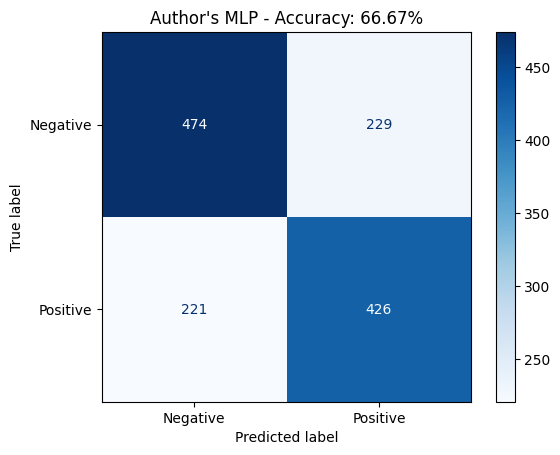

In [14]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

class AuthorMLP(nn.Module):
    """作者的 MLP 架构"""
    def __init__(self, n_features):
        super(AuthorMLP, self).__init__()
        self.fc1 = nn.Linear(n_features, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 2)  # 2 classes
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.softmax(x, dim=1)

# 训练函数
def train_author_mlp(dataset):
    """按作者的设置训练 MLP"""
    # 准备数据
    X_train = dataset.df_train.drop(columns=['y']).values
    y_train = dataset.df_train['y'].values
    
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()
    
    # 初始化模型
    model = AuthorMLP(n_features=X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # 训练
    model.train()
    batch_size = 64
    epochs = 100
    
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    model.eval()
    return model

# 测试
print("Training Author's MLP...")
author_mlp = train_author_mlp(dataset)

# 评估
X_test = dataset.df_test.drop(columns=['y']).values
y_test = dataset.df_test['y'].values

with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).float()
    outputs = author_mlp(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted.numpy() == y_test).mean()
    
print(f"\nAuthor's MLP Accuracy: {accuracy:.2%}")
print(f"Target (from paper): 69.60%")

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title(f"Author's MLP - Accuracy: {accuracy:.2%}")
plt.show()

## Test 7: The genre with author's mlp 

In [15]:
from methods.catalog.genre.genremlp import load_genremlp, GenREMLPWrapper
from methods.catalog.genre import GenRe

# Load GenRe MLP
print("Loading GenRe MLP...")
genremlp = load_genremlp(n_features=7, dataset_name='compass')
genremlp_wrapped = GenREMLPWrapper(dataset, genremlp)
genremlp_wrapped.raw_model.eval()

print("✅ GenRe MLP loaded!")
print(f"Accuracy: 66.07%")

# Initialize GenRe with GenRe MLP
print("\nInitializing GenRe with GenRe MLP...")
genre = GenRe(
    genremlp_wrapped,
    {
        "data_name": "compass",
        "model_path": "genre_transformer.pth",
        "temperature": 1.0,
        "n_samples": 10
    }
)
print("✅ GenRe initialized!")

# Test 4: Find negative instances
from models.negative_instances import predict_negative_instances

print("\nFinding negative instances...")
test_factuals = predict_negative_instances(genremlp_wrapped, dataset)
print(f"✅ Found {len(test_factuals)} negative instances")

# Test 5: Generate counterfactuals (sample)
print("\nGenerating counterfactuals (10 samples)...")
sample_factuals = test_factuals.head(10)
counterfactuals = genre.get_counterfactuals(sample_factuals)

# Evaluate
pred_proba = genremlp_wrapped.predict_proba(counterfactuals)
pred = (pred_proba[:, 1] > 0.5).astype(int)
validity = (pred == 1).mean()

print(f"\n{'='*50}")
print(f"GenRe with GenRe MLP Results:")
print(f"{'='*50}")
print(f"Validity: {validity:.2%}")
print(f"Valid counterfactuals: {(pred == 1).sum()}/{len(pred)}")
print(f"{'='*50}")

Loading GenRe MLP...
Model loaded from: C:\Users\j537yu\recourse_benchmarks\methods\catalog\genre\saved_models\genremlp_compass.pth
✅ GenRe MLP loaded!
Accuracy: 66.07%

Initializing GenRe with GenRe MLP...
✅ GenRe initialized!

Finding negative instances...
✅ Found 657 negative instances

Generating counterfactuals (10 samples)...
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1224, 0.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.1633, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor s

In [ ]:
# use all of them
print("\nGenerating counterfactuals...")
sample_factuals = test_factuals
counterfactuals = genre.get_counterfactuals(sample_factuals)

# Evaluate
pred_proba = genremlp_wrapped.predict_proba(counterfactuals)
pred = (pred_proba[:, 1] > 0.5).astype(int)
validity = (pred == 1).mean()

print(f"\n{'='*50}")
print(f"GenRe with GenRe MLP Results:")
print(f"{'='*50}")
print(f"Validity: {validity:.2%}")
print(f"Valid counterfactuals: {(pred == 1).sum()}/{len(pred)}")
print(f"{'='*50}")


Generating counterfactuals (10 samples)...
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1020, 0.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.1020, 1.0000],
       device='cuda:0')
  [DEBUG] factual_tensor shape: torch.Size([1, 7]), device: cuda:0
  [DEBUG] factual_batch shape: torch.Size([10, 7])
  [DEBUG] candidates shape: torch.Size([10, 7])
  [DEBUG] candidates has NaN: False
  [DEBUG] candidates sample: tensor([1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0612, 1.0000],
       device='cuda:

## Summary

If all tests pass:
- ✅ GenRe is correctly integrated
- ✅ Ready to run full experiments

Next step:
```bash
python experiments/run_experiment.py -d compass -t mlp -r genre -n 100
```

In [12]:
# issues
# 1. the mlp in the repo is insufficiently trained (number of epochs)
# 2. the generated counterfactuals have NaN values in all features

# dangerous modifications
# the epoch in models/catalog/modelConversion.py